In [2]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

19292


# 0. required packages for h5py

In [3]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [4]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH',
             'save_folder':r'D:\Pu_Temp\20201002_IgH_proB_iaa_dox+',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':True,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,13)

In [5]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 0.5

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4,
                                                                   _binary_per_th=99.7, 
                                                                   _morphology_size=2,
                                                                   _overwrite=True)
    fov._load_from_file('unique')
    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.15,
                                                             _cand_spot_intensity_th=0.75,
                                                             _save=True, 
                                                             _overwrite=True)
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 1.353s.
+ loading correction from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 158 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 85.816s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.060s.
+ loading unique from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ finish loading unique in 0.051s. 
- start select from 158 chromosomes with loss threshold=0.15


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1408: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


-- remove chr id 7, percentage of lost rounds:0.924.
-- remove chr id 13, percentage of lost rounds:0.903.
-- remove chr id 20, percentage of lost rounds:0.854.
-- remove chr id 92, percentage of lost rounds:0.826.
-- remove chr id 57, percentage of lost rounds:0.792.
-- remove chr id 152, percentage of lost rounds:0.792.
-- remove chr id 1, percentage of lost rounds:0.771.
-- remove chr id 73, percentage of lost rounds:0.771.
-- remove chr id 4, percentage of lost rounds:0.736.
-- remove chr id 10, percentage of lost rounds:0.729.
-- remove chr id 12, percentage of lost rounds:0.722.
-- remove chr id 11, percentage of lost rounds:0.681.
-- remove chr id 144, percentage of lost rounds:0.646.
-- remove chr id 141, percentage of lost rounds:0.611.
-- remove chr id 98, percentage of lost rounds:0.569.
-- remove chr id 73, percentage of lost rounds:0.542.
-- remove chr id 77, percentage of lost rounds:0.535.
-- remove chr id 57, percentage of lost rounds:0.528.
-- remove chr id 127, percen

-- checking unique, region:[96 97] in 0.002s.
-- checking unique, region:[ 99 100] in 0.003s.
-- checking unique, region:[102 103] in 0.003s.
-- checking unique, region:[105 106] in 0.001s.
-- checking unique, region:[108 109] in 0.000s.
-- checking unique, region:[111 112] in 0.000s.
-- checking unique, region:[114 115] in 0.000s.
-- checking unique, region:[323 321] in 0.000s.
-- checking unique, region:[326 324] in 0.016s.
-- checking unique, region:[329 327] in 0.000s.
-- checking unique, region:[332 330] in 0.000s.
-- checking unique, region:[335 333] in 0.000s.
-- checking unique, region:[339 337] in 0.000s.
-- checking unique, region:[342 340] in 0.000s.
-- checking unique, region:[345 343] in 0.015s.
-- checking unique, region:[348 346] in 0.000s.
-- checking unique, region:[351 349] in 0.000s.
-- checking unique, region:[354 352] in 0.000s.
-- checking unique, region:[357 355] in 0.000s.
-- checking unique, region:[360 358] in 0.016s.
-- checking unique, region:[363 361] in 0.

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_05.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_05.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_05.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_05.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drif

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3256.24s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_05.dax  in 12.964s
-- removing hot pixels for channels:['750'] in 6.324s
-- illumination correction for channels: 750, in 1.569s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 73.364s
-- finish correction in 118.032s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_05.hdf5
++ base attributes saved:['chrom_im

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_06.dax  in 14.047s
-- removing hot pixels for channels:['488'] in 6.748s
-- illumination correction for channels: 488, in 1.531s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.633s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
++ base attributes saved:['ref_im'] in 3.505s.
-- checking unique, region:[41 42] in 0.016s.
-- checking unique, region:[44 45] in 0.000s.
-- checking unique, region:[47 48] in 0.000s.
-- checking unique, region:[50 51] in 0.000s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.000s.
-- checking unique, region:[60 61] in 0.016s.
-- checking unique, region:[63 64] in 0.000s.
-- checking unique, region:[66 67] in 0.000s.
-- checking unique, region:[69 70] in 0.000s.
-- checking unique, region:[72 73] in 0.000s.
-- checking unique, reg

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_07.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_07.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_07.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_07.hdf5
++ base attributes saved:['analysis_folder', 'annotated_fol

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3270.43s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_07.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_07.dax  in 13.351s
-- removing hot pixels for channels:['750'] in 6.705s
-- illumination correction for channels: 750, in 1.505s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 73.486s
-- finish correction in 120.377s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_07.hdf5
++ base attributes saved:['chrom_im

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_08.dax  in 13.422s
-- removing hot pixels for channels:['488'] in 6.929s
-- illumination correction for channels: 488, in 1.476s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.125s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_08.hdf5
++ base attributes saved:['ref_im'] in 3.436s.
-- checking unique, region:[41 42] in 0.000s.
-- checking unique, region:[44 45] in 0.000s.
-- checking unique, region:[47 48] in 0.000s.
-- checking unique, region:[50 51] in 0.016s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.000s.
-- checking unique, region:[60 61] in 0.000s.
-- checking unique, region:[63 64] in 0.000s.
-- checking unique, region:[66 67] in 0.016s.
-- checking unique, region:[69 70] in 0.000s.
-- checking unique, region:[72 73] in 0.000s.
-- checking unique, reg

kept chromosomes: 131
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illu

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3183.76s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_09.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_10.dax  in 14.020s
-- removing hot pixels for channels:['488'] in 6.986s
-- illumination correction for channels: 488, in 1.564s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.882s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
++ base attributes saved:['ref_im'] in 3.599s.
-- checking unique, region:[41 42] in 0.000s.
-- checking unique, region:[44 45] in 0.016s.
-- checking unique, region:[47 48] in 0.000s.
-- checking unique, region:[50 51] in 0.000s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.000s.
-- checking unique, region:[60 61] in 0.000s.
-- checking unique, region:[63 64] in 0.016s.
-- checking unique, region:[66 67] in 0.000s.
-- checking unique, region:[69 70] in 0.000s.
-- checking unique, region:[72 73] in 0.000s.
-- checking unique, reg

-- remove chr id 94, percentage of lost rounds:0.222.
-- remove chr id 2, percentage of lost rounds:0.215.
-- remove chr id 53, percentage of lost rounds:0.215.
-- remove chr id 1, percentage of lost rounds:0.208.
-- remove chr id 108, percentage of lost rounds:0.208.
-- remove chr id 25, percentage of lost rounds:0.201.
-- remove chr id 56, percentage of lost rounds:0.201.
-- remove chr id 18, percentage of lost rounds:0.188.
-- remove chr id 66, percentage of lost rounds:0.188.
-- remove chr id 104, percentage of lost rounds:0.188.
-- remove chr id 32, percentage of lost rounds:0.181.
-- remove chr id 112, percentage of lost rounds:0.174.
-- remove chr id 8, percentage of lost rounds:0.167.
-- remove chr id 65, percentage of lost rounds:0.167.
-- remove chr id 104, percentage of lost rounds:0.167.
-- remove chr id 111, percentage of lost rounds:0.167.
-- 114 chromosomes are kept.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
++ base attributes s

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3234.06s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_11.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_12.dax  in 14.080s
-- removing hot pixels for channels:['488'] in 6.753s
-- illumination correction for channels: 488, in 1.568s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.707s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5
++ base attributes saved:['ref_im'] in 3.573s.
-- checking unique, region:[41 42] in 0.016s.
-- checking unique, region:[44 45] in 0.031s.
-- checking unique, region:[47 48] in 0.016s.
-- checking unique, region:[50 51] in 0.000s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.000s.
-- checking unique, region:[60 61] in 0.000s.
-- checking unique, region:[63 64] in 0.016s.
-- checking unique, region:[66 67] in 0.000s.
-- checking unique, region:[69 70] in 0.000s.
-- checking unique, region:[72 73] in 0.000s.
-- checking unique, reg

-- remove chr id 127, percentage of lost rounds:0.215.
-- remove chr id 12, percentage of lost rounds:0.208.
-- remove chr id 51, percentage of lost rounds:0.208.
-- remove chr id 74, percentage of lost rounds:0.208.
-- remove chr id 6, percentage of lost rounds:0.201.
-- remove chr id 20, percentage of lost rounds:0.194.
-- remove chr id 121, percentage of lost rounds:0.188.
-- remove chr id 121, percentage of lost rounds:0.188.
-- remove chr id 47, percentage of lost rounds:0.174.
-- remove chr id 82, percentage of lost rounds:0.167.
-- remove chr id 19, percentage of lost rounds:0.160.
-- remove chr id 73, percentage of lost rounds:0.160.
-- remove chr id 19, percentage of lost rounds:0.153.
-- remove chr id 62, percentage of lost rounds:0.153.
-- remove chr id 66, percentage of lost rounds:0.153.
-- 114 chromosomes are kept.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5
++ base attributes saved:['chrom_coords'] in 0.071s.
kept chromosomes: 114

In [6]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 0.5
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 12.116s
-- collapse all regions into 1d.


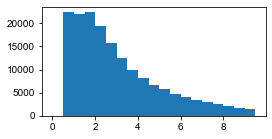

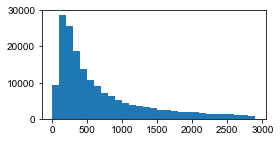

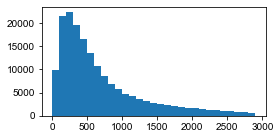

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 10.726s
-- region kept: 0.7905
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 8.641s
-- collapse all regions into 1d.


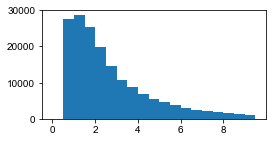

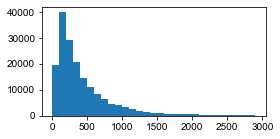

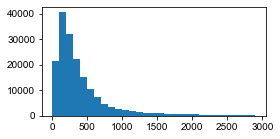

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 10.823s
-- region kept: 0.9455
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 8.742s
-- collapse all regions into 1d.


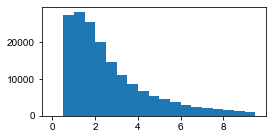

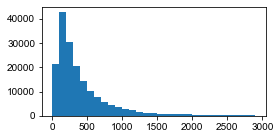

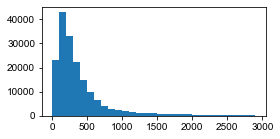

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 10.963s
-- region kept: 0.9808
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 8.734s
-- collapse all regions into 1d.


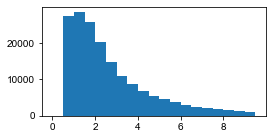

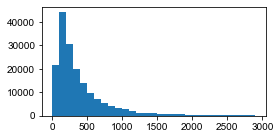

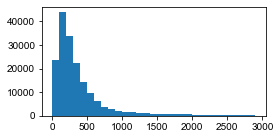

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 11.000s
-- region kept: 0.9906
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 8.631s
-- collapse all regions into 1d.


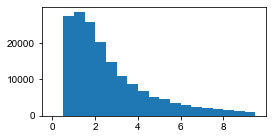

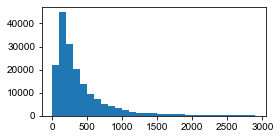

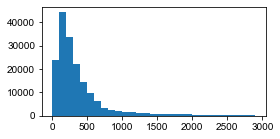

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 10.767s
-- region kept: 0.9939
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 8.838s
-- collapse all regions into 1d.


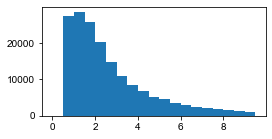

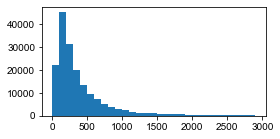

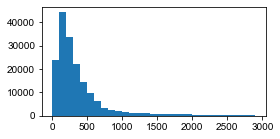

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 10.897s
-- region kept: 0.9957


In [7]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,10,0.5))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

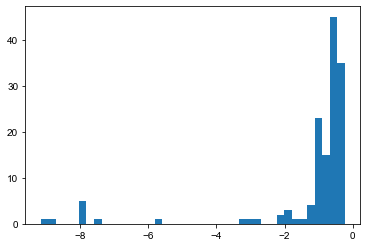

In [16]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[sel_iter][1]), 40)
plt.show()

In [8]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
distmap_list = []
score_th = np.exp(-3)
bad_spot_percentage = 0.6
for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _kept_hzxys[_scores < score_th] = np.nan
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

0.13500703791677662


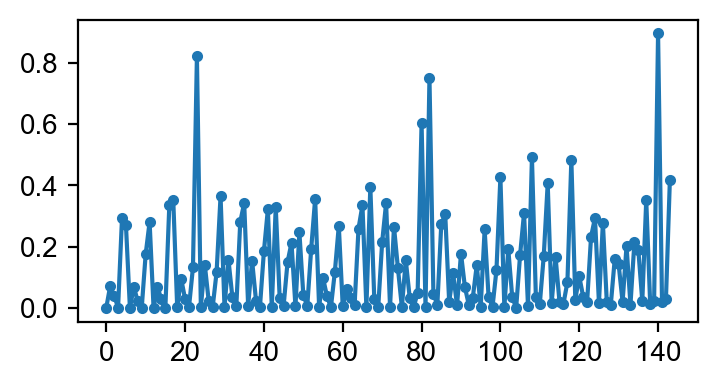

In [9]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [15]:
len(chrom_coords)

1264

In [13]:
kept_inds = np.where(loss_rates<0.2)[0]

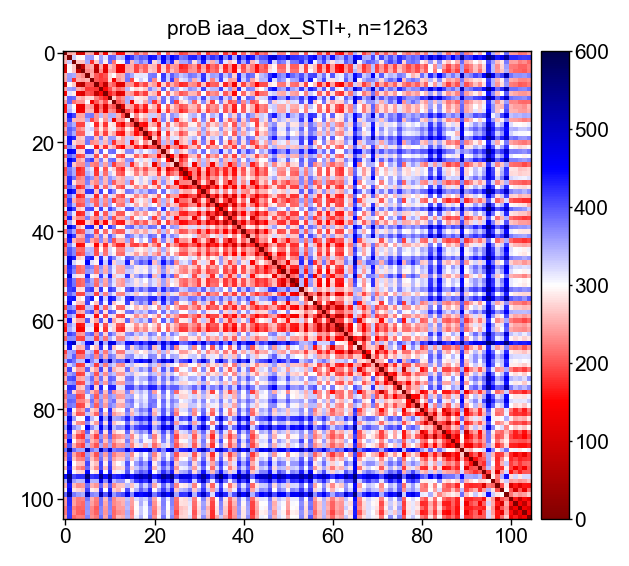

In [14]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB iaa_dox_STI+, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

In [ ]:
%matplotlib notebook
chrom_id = 8

valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#distmap_list[chrom_id],
                                               distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               color_limits=[100,700],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB bone marrow IgH+/+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(#final_dna_hzxys_list[chrom_id][:,1:], 
                                                     final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=400, 
                                                     line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()